In [1]:
import matplotlib.pyplot as plt
with open("piste.pgm", 'rb') as pgmf:
    img = plt.imread(pgmf)

In [2]:
import numpy as np

In [3]:
pose = [900, 500, np.pi]

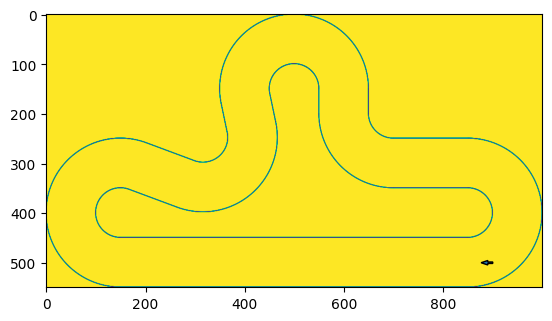

In [4]:
%matplotlib inline
imgplot = plt.imshow(img)
plt.arrow(pose[0], pose[1], 10 * np.cos(pose[2]), 10 * np.sin(pose[2]), width=3.0)

In [5]:
img_t = np.transpose(img)
img_t = np.flip(img_t, 1)

In [6]:
threshold = 250

In [7]:
width = img_t.shape[0]
height = img_t.shape[1]
t = np.mgrid[:width, :height]
t = np.stack((t[0], t[1]), axis=2)

In [8]:
points = t[img_t < threshold]

In [9]:
pose = [900, 50, np.pi]
pose = [500, 50, np.radians(-3)]
#pose = [500, 50, 0]
#pose = [850, 52, 3.0892327760299634]
pose = [753, 77, 2.792526803190927]
pose = [ 166.648113,  213.283612,  0.20943951]
pose = [ 215.555493,  223.679196,  0.20943951]
pose = [ 260.735529,  234.518542,  0.2268928 ]
pose = [107.199835, 189.184783, 1.30899694]

In [10]:
theta = -pose[2]
rot_matrix = np.array([[np.cos(theta), -np.sin(theta),0],
                       [np.sin(theta), np.cos(theta), 0],
                       [0, 0, 1]])

trans_matrix = np.array([[1, 0, -pose[0]],
                       [0, 1, -pose[1]],
                       [0, 0, 1]])

points_pose = np.transpose(trans_matrix @ np.vstack([np.transpose(points), np.ones(points.shape[0])]))
points_pose = np.transpose(rot_matrix @ np.transpose(points_pose))

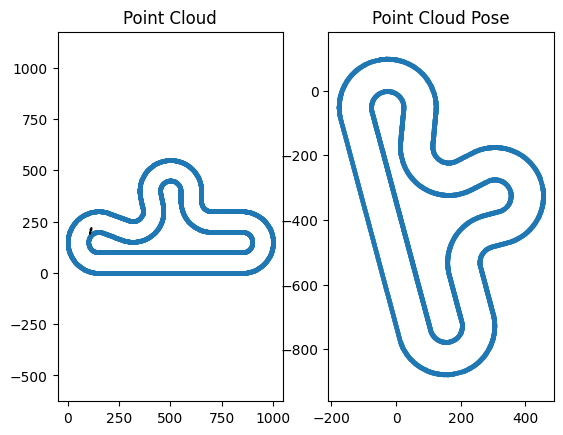

In [11]:
fig, axs = plt.subplots(1, 2)
axs[0].set_title("Point Cloud")  
axs[0].axis('equal')
axs[0].scatter(points[:, 0], points[:, 1], s=3.0)
axs[0].arrow(pose[0], pose[1], 20 * np.cos(pose[2]), 20 * np.sin(pose[2]), width=3.0)
axs[1].set_title("Point Cloud Pose")  
axs[1].axis('equal')
axs[1].scatter(points_pose[:, 0], points_pose[:, 1], s=3.0)

In [12]:
import cmath
def cart2polC(xyz):
    x, y, z = xyz
    return(cmath.polar(complex(x, y))) # rho, phi
def convert_array(arr):
    theta = []
    r = []
    for x in arr:
        rho, phi = cart2polC(x)
        theta.append(phi)
        r.append(rho)
    return theta, r    

In [13]:
theta, r = convert_array(points_pose)
polar_points = np.column_stack((np.array(theta), np.array(r)))

In [14]:
# Debugging
#polar_points = polar_points[(polar_points[:, 0] > np.radians(-135)) & (polar_points[:, 0] < np.radians(-90))]

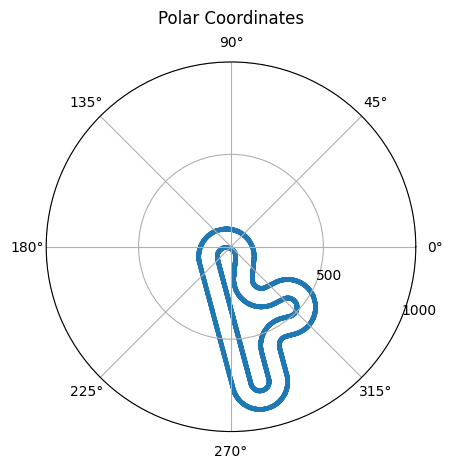

In [15]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(polar_points[:, 0], polar_points[:, 1], s=3.0)
ax.set_rmax(1000)
ax.set_rticks([500, 1000])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("Polar Coordinates", va='bottom')
plt.show()

In [16]:
min_range = 2.0
max_range = 12000.0
resolution = 1 # in degrees
def lidar_filer(raw_scann):
    scann = []
    samples = np.arange(-np.pi, np.pi, np.radians(resolution))
    for sample in samples:
        mask = (raw_scann[:,0] > sample - np.radians(resolution) / 2) & (raw_scann[:,0] < sample + np.radians(resolution) / 2)
        if sum(mask) == 0:
            dist = 0
        else:
            dist = raw_scann[mask][:, 1].min()
        scann.append(dist)
        if dist > max_range:
            scann[-1] = None
        if dist < min_range:
            scann[-1] = None
    return np.roll(np.array(scann), int(np.pi / np.radians(resolution)))       

In [17]:
lidar_scann = lidar_filer(polar_points)

In [18]:
plot_scann = np.stack((np.arange(0, 2 * np.pi, np.radians(resolution)), lidar_scann), axis=1)
plot_scann = plot_scann[plot_scann[:, 1] != np.array(None)]

Text(0.5, 1.0, 'Lidar Scann')

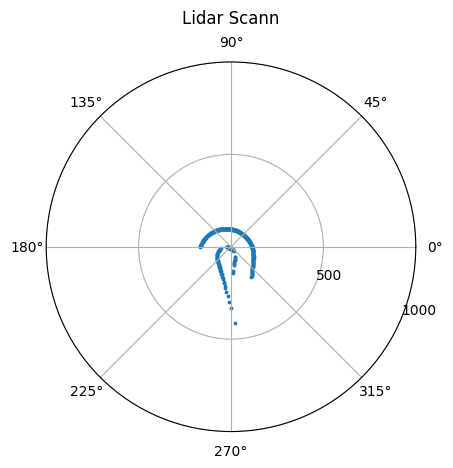

In [19]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(plot_scann[:, 0], plot_scann[:, 1], s=3.0)
ax.set_rmax(1000)
ax.set_rticks([500, 1000])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("Lidar Scann", va='bottom')